In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict

import laspy
import rasterio
from rasterio.transform import AffineTransformer
from rasterio.plot import show
from shapely.geometry import Polygon, Point, box
from shapely.prepared import prep

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
### ===============================================================================================
### Dataset calibration (calibrate las with raster)
### ===============================================================================================
raster = rasterio.open(r"data/20250613_UAV-Photo_Sandhausen_ortho_2cm_clipped.tif")
raster.count

4

Text(0.5, 1.0, 'Orthophoto')

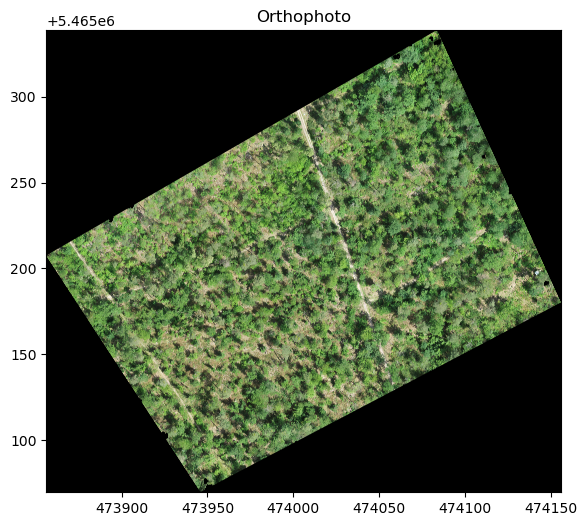

In [3]:
# Plot orthophoto
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(raster.read([1, 2, 3]).transpose(1, 2, 0), extent=[raster.bounds.left, raster.bounds.right, raster.bounds.bottom, raster.bounds.top])
ax.set_title("Orthophoto")

In [4]:
# Create a mask for nonzero values
bands = raster.read(1)

In [5]:
# Obtain raster bounds
row, col = np.where(bands != 0)
bottom_left = [row.min(), np.average(np.where(bands[row.min(), ] != 0))]
upper_left = [np.average(np.where(bands[:, col.min()] != 0)), col.min()]
bottom_right = [np.average(np.where(bands[:, col.max()] != 0)), col.max()]
upper_right = [row.max(), np.average(np.where(bands[row.max(), ] != 0))]
print(f"Current raster height: {raster.height}, width: {raster.width}")
print(f"Bottom left: {bottom_left}, bottom right: {bottom_right}, upper_left: {upper_left}, upper_right: {upper_right}")

Current raster height: 13460, width: 14986
Bottom left: [np.int64(0), np.float64(11377.0)], bottom right: [np.float64(7933.0), np.int64(14985)], upper_left: [np.float64(6572.0), np.int64(0)], upper_right: [np.int64(13459), np.float64(4490.0)]


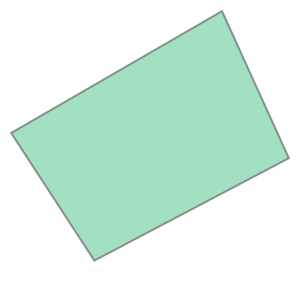

In [6]:
### ===============================================================================================
### Create polygon to extract points in the raster bounds
### ===============================================================================================
# Raster pixel position to the point cloud coordinates
transformer = AffineTransformer(raster.transform)
bottom_left_x,  bottom_left_y = transformer.xy(bottom_left[0], bottom_left[1])
bottom_right_x,  bottom_right_y = transformer.xy(bottom_right[0], bottom_right[1])
upper_left_x,  upper_left_y = transformer.xy(upper_left[0], upper_left[1])
upper_right_x,  upper_right_y = transformer.xy(upper_right[0], upper_right[1])

raster_polygon = Polygon([(bottom_left_x, bottom_left_y),
                          (bottom_right_x, bottom_right_y),
                          (upper_right_x, upper_right_y),
                          (upper_left_x, upper_left_y),
                          ])
raster_polygon

In [ ]:
refined_las = laspy.LasData(las.header)
prep_polygon = prep(raster_polygon)
polygon_mask = np.array([prep_polygon.contains(Point(x, y)) for x, y in zip(las.x, las.y)])
refined_las.points = las.points[polygon_mask]
refined_las.write(out_file)

In [2]:
in_file_1 = r"data/20240607_UAV-Photo_Sandhausen_2cm.laz"
out_file_1 = r"data/20240607_UAV-Photo_Sandhausen_2cm_refined.laz"

In [3]:
in_file_2 = r"data/20250613_UAV-Photo_Sandhausen_2cm.laz"
out_file_2 = r"data/20250613_UAV-Photo_Sandhausen_2cm_refined.laz"

In [30]:
in_file = [in_file_1, in_file_2]

In [54]:
### ===============================================================================================
### Load las dataset
### ===============================================================================================
las_1 = laspy.read(in_file_1)
las_2 = laspy.read(in_file_2)

In [ ]:
# Las information
print(np.unique(las.classification))
print(list(las.point_format.standard_dimension_names))
print(list(las.point_format.extra_dimension_names))
print(las.header.scale)
print(las.header.offset)

### Downsample the point cloud

In [5]:
hist1, bins1 = np.histogram(las_1.z, bins=1000)
hist2, bins2 = np.histogram(las_2.z, bins=1000)

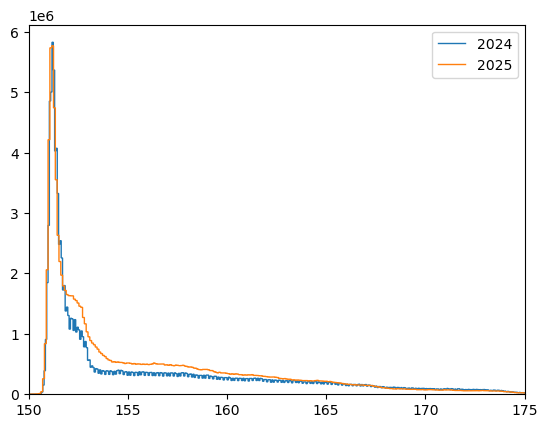

In [28]:
fig, ax = plt.subplots(1, 1)
ax.stairs(hist1, bins1, label="2024")
ax.stairs(hist2, bins2, label="2025")
ax.set_xlim(150, 175)
ax.legend()

In [77]:
near_ground_1 = np.less(las_1.z, np.full(las_1.z.shape, 152))  ## 1D array

In [78]:
near_ground_2 = np.less(las_2.z, np.full(las_2.z.shape, 152))

In [82]:
# set every 10th near ground to false, in order to downsample
idx_1 = np.flatnonzero(near_ground_1)
flip = idx_1[9::10]
near_ground_1[flip] = False

In [83]:
near_ground_1.shape
near_ground_1.sum()

np.int64(47384542)